# Collective states

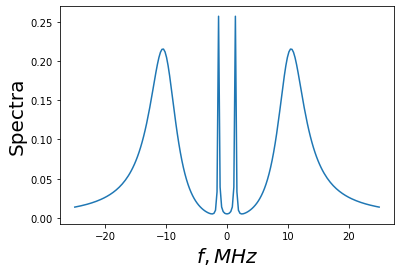

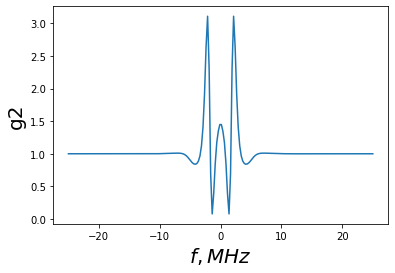

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May 21 21:07:37 2020

@author: azizasuleymanzade
"""
import matplotlib.pyplot as plt
import numpy as np
# make qutip available in the rest of the notebook
import qutip as qt

N_SITES = 5 # optical/mmwave cavity, E, R, R2 states
SITE_EXCITE = 3 # arbitrary
N_EXCITE = 2 # number of excitations
N_TH_OPT = 0
N_TH_MM = 0

G = 'G';KAPPA = 'KAPPA';GAMMA = 'GAMMA'; dla = 'dla'; dlc = 'dlc';Omega_opt = 'Omega_opt'
GAMMA_R = 'GAMMA_R'; dr = 'dr';dr2 = 'dr2'; Omega_R = 'Omega_R'; dmm = 'dmm'; KAPPA_MM = 'KAPPA_MM'
G_MM = 'G_MM'; Omega_mm = 'Omega_mm'

DIM = [SITE_EXCITE]*N_SITES
nstates, state2idx, idx2state  = qt.enr_state_dictionaries(DIM, N_EXCITE)
a_opt, a_e, a_r, a_r2, a_mm = qt.enr_destroy(DIM, N_EXCITE)

#generate a list of photonic parameters 
PARAMETERS = {
              KAPPA: 5, 
              GAMMA: 6, 
              dlc: 0,
              Omega_opt: 0.1,
              GAMMA_R: 0.1, 
              Omega_R: 2, 
              KAPPA_MM: 0.1, 
              G: 10, 
              dla: 0, 
              dr: 0, 
              dr2: 0, 
              Omega_R: 2, 
              dmm: 0,
              G_MM: 2}

#Bare Hamiltonian components
Hopt = a_opt.dag()*a_opt
Hmm = a_mm.dag()*a_mm
Vopt = a_opt + a_opt.dag() #driving of the optical cavity with coherent light
Ha= [a_e.dag()*a_e ,a_r.dag()*a_r,a_r2.dag()*a_r2]
Hi = [a_e.dag()*a_opt + a_opt.dag()*a_e, a_e.dag()*a_r + a_r.dag()*a_e, a_r.dag()*a_mm*a_r2 \
      + a_mm.dag()*a_r2.dag()*a_r]

def get_Hamilt_cops(pr, dprobe):
    Htotal = (pr[dlc] + dprobe)* Hopt +\
             (pr[dla] + dprobe)* Ha[0] +\
            (pr[dr] + dprobe)* Ha[1] +\
            (pr[dr2]+ dprobe)* Ha[2] +\
             (pr[dmm] + dprobe)* Hmm +\
             pr[G] * Hi[0] +\
             pr[Omega_R] * Hi[1] +\
             pr[G_MM] * Hi[2] +\
             pr[Omega_opt]*Vopt
    collapse = [np.sqrt((pr[KAPPA]) * (1 + N_TH_OPT))* a_opt,\
                np.sqrt((pr[KAPPA]) * N_TH_OPT)* a_opt.dag(),\
                np.sqrt((pr[KAPPA_MM]) * (1 + N_TH_MM))* a_mm,\
                np.sqrt((pr[KAPPA_MM]) * N_TH_MM)* a_mm.dag(),\
                np.sqrt(pr[GAMMA])* a_e,\
                np.sqrt(pr[GAMMA_R])* a_r,\
                np.sqrt(pr[GAMMA_R])* a_r2,\
                    ]
    return Htotal, collapse

scan = np.linspace(-25, 25, 200)

#Calculate steady state spectra
result_Hopt = []
result_g2 = []
for i in range(0,len(scan)):
    dprobe  =scan[i]
    H, c_ops = get_Hamilt_cops(PARAMETERS,dprobe)
    rho_ss = qt.steadystate(H, c_ops)
    Hopt_expect = qt.expect(Hopt, rho_ss)
    g2_expect = qt.expect(a_opt.dag()*a_opt.dag()*a_opt*a_opt, rho_ss)
    result_Hopt.append(Hopt_expect/((PARAMETERS[Omega_opt]**2)/(PARAMETERS[KAPPA]/2)**2))
    result_g2.append(1/2 *g2_expect/(1/2 *Hopt_expect**2))

fig1, axes = plt.subplots(1,1)
axes.plot(scan, result_Hopt)
#axes.set_xlim(-20, 20)
axes.set_xlabel(r'$f, MHz$', fontsize=20)
axes.set_ylabel(r"Spectra", fontsize=20);

fig1, axes = plt.subplots(1,1)
axes.plot(scan, result_g2)
#axes.set_xlim(-20, 20)
axes.set_xlabel(r'$f, MHz$', fontsize=20)
axes.set_ylabel(r"g2", fontsize=20);

In [9]:
time = np.linspace(0, 20, 10000)
scan = np.linspace(-8, 8, 200)
g2_tau_cor = []
G2 = []
exp_nphon_me_scan = []
for i in range(0,len(scan)):
    dprobe  =scan[i]
    H4_0, c_ops_0 = get_Hamilt_cops(PARAMETERS, dprobe)
    rho_ss = qt.steadystate(H4_0, c_ops_0)
    rho_pj = a_opt*rho_ss*a_opt.dag()/((a_opt*rho_ss*a_opt.dag()).tr())
    G2 = qt.correlation_3op_1t(H4_0, rho_ss, time, c_ops_0, a_opt.dag(), a_opt.dag()*a_opt, a_opt)
    exp_nphot_me = qt.mesolve(H4_0, rho_ss, time, c_ops_0, [Hopt]).expect[0]
    exp_nphon_me_scan.append(exp_nphot_me)
    g2_tau_den = exp_nphot_me[0] * exp_nphot_me
    g2 = G2/g2_tau_den
    g2_tau_cor.append(g2)


/Users/azizasuleymanzade/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


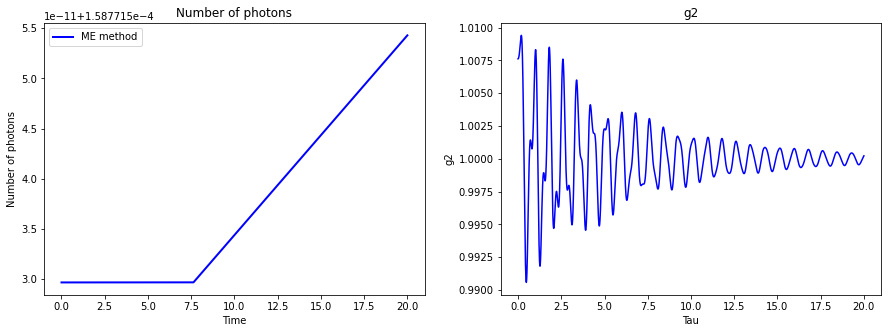

In [10]:
#%%
# plot the spectra
fig = plt.figure(figsize=(15,5))
ax = fig.subplots(1, 2)
ax[0].plot(time, exp_nphon_me_scan[0], 'b', lw=2, label='ME method')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Number of photons')
ax[0].set_title('Number of photons')
#ax[0].set_xlim(0, 200)
ax[0].legend()
ax[1].plot(time, g2_tau_cor[0], 'b')
ax[1].set_xlabel('Tau')
ax[1].set_ylabel('g2')
ax[1].set_title('g2')
#ax[1].set_xlim(0, 200)
#ax[1].set_ylim(-1, 2)
plt.show()

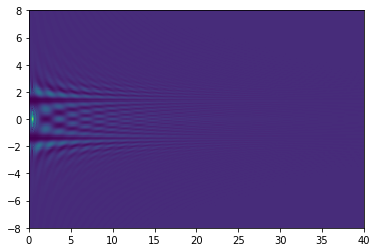

In [285]:
plt.pcolor(time, scan, abs(np.array(g2_tau_cor).real))

## g2(tau) by hand

In [266]:
time = np.linspace(0, 40, 10000)
scan = np.linspace(-8, 8, 200)
g2_tau = []
g2_0 = []
for i in range(0,len(scan)):
    dprobe  =scan[i]
    H4_0, c_ops_0 = get_Hamilt_cops(PARAMETERS, dprobe)
    rho_ss = qt.steadystate(H4_0, c_ops_0)
    rho_pj = a_opt*rho_ss*a_opt.dag()/((a_opt*rho_ss*a_opt.dag()).tr())
    g2_tau_num = qt.mesolve(H4_0, rho_pj, time, c_ops_0, [Hopt]).expect[0]
    g2_tau_den = qt.mesolve(H4_0, rho_ss, time, c_ops_0, [Hopt]).expect[0]
    g2 = g2_tau_num/g2_tau_den
    g2_tau.append(g2)
    g2_0.append(g2[0])

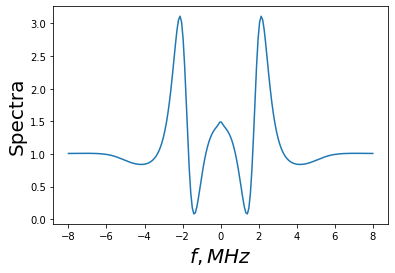

In [267]:
fig1, axes = plt.subplots(1,1)
axes.plot(scan, np.transpose(g2_tau)[0])
#axes.set_xlim(0, 1)
axes.set_xlabel(r'$f, MHz$', fontsize=20)
axes.set_ylabel(r"Spectra", fontsize=20);

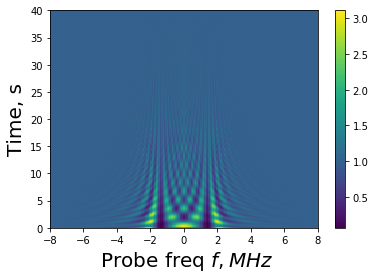

In [394]:
fig1, axes = plt.subplots(1,1)
axes.pcolor(scan,time, np.transpose(g2_tau))
axes.set_xlabel(r' Probe freq $f, MHz$', fontsize=20)
axes.set_ylabel(r"Time, s", fontsize=20)
mesh = axes.pcolormesh(scan, time ,np.transpose(g2_tau))
plt.colorbar(mesh)

Text(0.5, 0, '$tau, s$')

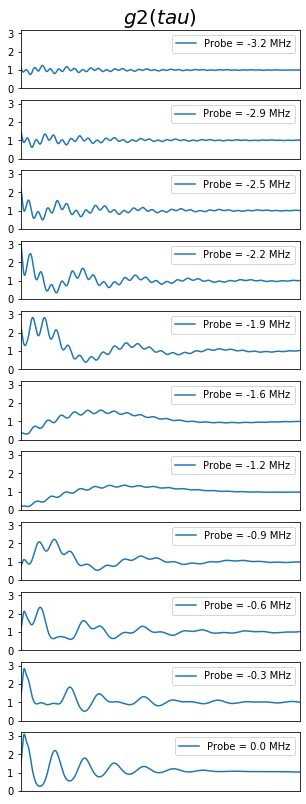

In [395]:
fig1, axes = plt.subplots(11, figsize=(5,14))
j  =0 
axes[j].set_title(r'$g2(tau)$', fontsize=20)
for i in range(60,102, 4):    
    axes[j].plot(time, g2_tau[i])
    axes[j].set_ylim(0, 3.2)
    axes[j].set_xlim(0, 30)
    if j < 19:
        axes[j].get_xaxis().set_visible(False)
    axes[j].get_yaxis().set_ticks([0,1,2,3])
    axes[j].legend(['Probe = %.1f MHz' % scan[i]], loc ='upper right')
    j = j+1
axes[j-1].get_xaxis().set_ticks([0,10,20])
axes[j-1].set_xlabel(r'$tau, s$', fontsize=20)

In [348]:
scan[70]

-2.3718592964824117

In [ ]:
fig1, axes = plt.subplots(1,1)
axes.plot(scan, g2_0)
#axes.set_xlim(0, 1)
axes.set_xlabel(r'$f, MHz$', fontsize=20)
axes.set_ylabel(r"Spectra", fontsize=20);

In [15]:
time = np.linspace(0, 5, 20)

g1 = []
g2 = []
for i in range(0,len(scan)):
    LIGHT_PARAMETERS[dlc] =scan[i]
    ATOM_PARAMETERS[dla] = [scan[i] for j in range(NUMBER_OF_ATOMS)]
    c_ops_scan = get_total_collapse_ops(LIGHT_PARAMETERS)
    Htotal_many_scan = get_total_Hamilt(get_many_atom_Ha(get_many_atom_Ha_bare(NUMBER_OF_ATOMS, at_ge_many, at_er_many, at_rr2_many), ATOM_PARAMETERS, NUMBER_OF_ATOMS),\
                                   get_many_atom_Hopt(Hopt, LIGHT_PARAMETERS),\
                                   get_many_atom_Hmm(Hmm, ATOM_PARAMETERS),\
                                   get_many_atom_Hi(get_many_atom_Hi_bare(NUMBER_OF_ATOMS, at_ge_many, at_er_many, at_rr2_many, a_opt, a_mm), ATOM_PARAMETERS, NUMBER_OF_ATOMS),\
                                   get_many_atom_Hdrive(Vopt, LIGHT_PARAMETERS))
    #result.append(qt.expect(Hopt, qt.steadystate(Htotal_many, c_ops, method ='power',use_rcm=True, maxiter = 100)))
    avg = qt.mcsolve(Htotal_many_scan, psi0, time, c_ops_scan, [a_opt.dag()*a_opt]).expect[0]
    G2 = qt.correlation_3op_1t(Htotal_many_scan, psi0, time, c_ops_scan, a_opt.dag(), a_opt.dag()*a_opt, a_opt, solver='mc')
    g2_temp = G2/(avg[0]*avg)
    g2.append(g2_temp)
    g1.append(avg)

10.0%. Run time:   3.95s. Est. time left: 00:00:00:35
20.0%. Run time:   4.48s. Est. time left: 00:00:00:17
30.0%. Run time:   5.03s. Est. time left: 00:00:00:11
40.0%. Run time:   5.63s. Est. time left: 00:00:00:08
50.0%. Run time:   6.22s. Est. time left: 00:00:00:06
60.0%. Run time:   6.84s. Est. time left: 00:00:00:04
70.0%. Run time:   7.40s. Est. time left: 00:00:00:03
80.0%. Run time:   7.93s. Est. time left: 00:00:00:01
90.0%. Run time:   8.49s. Est. time left: 00:00:00:00
100.0%. Run time:   9.00s. Est. time left: 00:00:00:00
Total run time:   9.07s
10.0%. Run time:   3.93s. Est. time left: 00:00:00:35
20.0%. Run time:   4.47s. Est. time left: 00:00:00:17
30.0%. Run time:   5.00s. Est. time left: 00:00:00:11
40.0%. Run time:   5.53s. Est. time left: 00:00:00:08
50.0%. Run time:   6.08s. Est. time left: 00:00:00:06
60.0%. Run time:   6.62s. Est. time left: 00:00:00:04
70.0%. Run time:   7.13s. Est. time left: 00:00:00:03
80.0%. Run time:   7.67s. Est. time left: 00:00:00:01
90.

KeyboardInterrupt: 

In [214]:
from IPython.display import display, Math, Latex

g2 =[]
for j in range(len(scan)):

    ncollapse_e = [result1[j].col_times[i].size
    for i in range(500)]

    Pm_e = np.histogram(ncollapse_e, bins=range(20), density=True)[0]

    # calculate the measured degree of second-order coherence
    g2.append(sum([p * m * (m - 1) for m,p in enumerate(Pm_e)]))

C:\Users\Aziza\anaconda3\envs\qutip-env\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


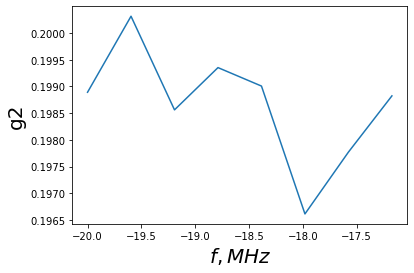

In [35]:
fig1, axes = plt.subplots(1,1)
axes.plot(scan[:8]/(2*np.pi),(np.array(g2).T)[19])
#axes.set_xlim(-20, 20)
axes.set_xlabel(r'$f, MHz$', fontsize=20)
axes.set_ylabel(r"g2", fontsize=20);

C:\Users\Aziza\anaconda3\envs\qutip-env\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


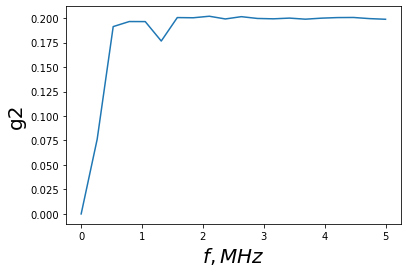

In [48]:
fig1, axes = plt.subplots(1,1)
axes.plot(time,g2[7])
#axes.set_xlim(-20, 20)
axes.set_xlabel(r'$f, MHz$', fontsize=20)
axes.set_ylabel(r"g2", fontsize=20);

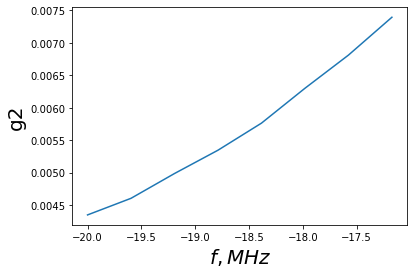

In [54]:
fig1, axes = plt.subplots(1,1)
axes.plot(scan[:8]/(2*np.pi),(np.array(g1).T)[19])
#axes.set_xlim(-20, 20)
axes.set_xlabel(r'$f, MHz$', fontsize=20)
axes.set_ylabel(r"g2", fontsize=20);

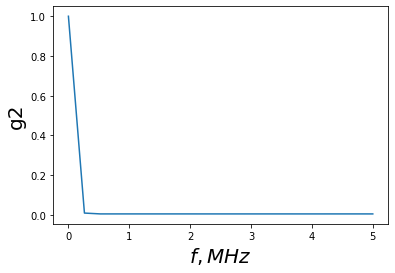

In [51]:
fig1, axes = plt.subplots(1,1)
axes.plot(time,g1[1])
#axes.set_xlim(-20, 20)
axes.set_xlabel(r'$f, MHz$', fontsize=20)
axes.set_ylabel(r"g2", fontsize=20);

In [77]:
time = np.linspace(0, 3, 20)

g1_3atoms = []
#g2 = []
for i in range(0,len(scan)):
    LIGHT_PARAMETERS[dlc] =scan[i]
    ATOM_PARAMETERS[dla] = [scan[i] for j in range(NUMBER_OF_ATOMS)]
    c_ops_scan = get_total_collapse_ops(LIGHT_PARAMETERS)
    Htotal_many_scan = get_total_Hamilt(get_many_atom_Ha(get_many_atom_Ha_bare(NUMBER_OF_ATOMS, at_ge_many, at_er_many, at_rr2_many), ATOM_PARAMETERS, NUMBER_OF_ATOMS),\
                                   get_many_atom_Hopt(Hopt, LIGHT_PARAMETERS),\
                                   get_many_atom_Hmm(Hmm, ATOM_PARAMETERS),\
                                   get_many_atom_Hi(get_many_atom_Hi_bare(NUMBER_OF_ATOMS, at_ge_many, at_er_many, at_rr2_many, a_opt, a_mm), ATOM_PARAMETERS, NUMBER_OF_ATOMS),\
                                   get_many_atom_Hdrive(Vopt, LIGHT_PARAMETERS))
    #result.append(qt.expect(Hopt, qt.steadystate(Htotal_many, c_ops, method ='power',use_rcm=True, maxiter = 100)))
    avg = qt.mcsolve(Htotal_many_scan, psi0, time, c_ops_scan, [a_opt.dag()*a_opt]).expect[0]
    #G2 = qt.correlation_3op_1t(Htotal_many_scan, psi0, time, c_ops_scan, a_opt.dag(), a_opt.dag()*a_opt, a_opt, solver='mc')
    #g2_temp = G2/(avg[0]*avg)
    #g2.append(g2_temp)
    g1_3atoms.append(avg)


10.0%. Run time:   4.33s. Est. time left: 00:00:00:38
20.0%. Run time:   5.12s. Est. time left: 00:00:00:20
30.0%. Run time:   5.94s. Est. time left: 00:00:00:13
40.0%. Run time:   6.73s. Est. time left: 00:00:00:10
50.0%. Run time:   7.48s. Est. time left: 00:00:00:07
60.0%. Run time:   8.25s. Est. time left: 00:00:00:05
70.0%. Run time:   9.03s. Est. time left: 00:00:00:03
80.0%. Run time:   9.74s. Est. time left: 00:00:00:02
90.0%. Run time:  10.48s. Est. time left: 00:00:00:01
100.0%. Run time:  11.21s. Est. time left: 00:00:00:00
Total run time:  11.25s
10.0%. Run time:   4.29s. Est. time left: 00:00:00:38
20.0%. Run time:   5.02s. Est. time left: 00:00:00:20
30.0%. Run time:   5.74s. Est. time left: 00:00:00:13
40.0%. Run time:   6.47s. Est. time left: 00:00:00:09
50.0%. Run time:   7.17s. Est. time left: 00:00:00:07
60.0%. Run time:   8.00s. Est. time left: 00:00:00:05
70.0%. Run time:   8.69s. Est. time left: 00:00:00:03
80.0%. Run time:   9.42s. Est. time left: 00:00:00:02
90.

70.0%. Run time:   7.25s. Est. time left: 00:00:00:03
80.0%. Run time:   7.77s. Est. time left: 00:00:00:01
90.0%. Run time:   8.32s. Est. time left: 00:00:00:00
100.0%. Run time:   8.82s. Est. time left: 00:00:00:00
Total run time:   8.88s
10.0%. Run time:   3.99s. Est. time left: 00:00:00:35
20.0%. Run time:   4.50s. Est. time left: 00:00:00:18
30.0%. Run time:   5.01s. Est. time left: 00:00:00:11
40.0%. Run time:   5.56s. Est. time left: 00:00:00:08
50.0%. Run time:   6.11s. Est. time left: 00:00:00:06
60.0%. Run time:   6.63s. Est. time left: 00:00:00:04
70.0%. Run time:   7.15s. Est. time left: 00:00:00:03
80.0%. Run time:   7.69s. Est. time left: 00:00:00:01
90.0%. Run time:   8.22s. Est. time left: 00:00:00:00
100.0%. Run time:   8.72s. Est. time left: 00:00:00:00
Total run time:   8.77s
10.0%. Run time:   4.04s. Est. time left: 00:00:00:36
20.0%. Run time:   4.55s. Est. time left: 00:00:00:18
30.0%. Run time:   5.06s. Est. time left: 00:00:00:11
40.0%. Run time:   5.57s. Est. t

20.0%. Run time:   4.23s. Est. time left: 00:00:00:16
30.0%. Run time:   4.62s. Est. time left: 00:00:00:10
40.0%. Run time:   5.01s. Est. time left: 00:00:00:07
50.0%. Run time:   5.39s. Est. time left: 00:00:00:05
60.0%. Run time:   5.78s. Est. time left: 00:00:00:03
70.0%. Run time:   6.17s. Est. time left: 00:00:00:02
80.0%. Run time:   6.57s. Est. time left: 00:00:00:01
90.0%. Run time:   6.95s. Est. time left: 00:00:00:00
100.0%. Run time:   7.31s. Est. time left: 00:00:00:00
Total run time:   7.38s
10.0%. Run time:   3.81s. Est. time left: 00:00:00:34
20.0%. Run time:   4.17s. Est. time left: 00:00:00:16
30.0%. Run time:   4.57s. Est. time left: 00:00:00:10
40.0%. Run time:   4.92s. Est. time left: 00:00:00:07
50.0%. Run time:   5.31s. Est. time left: 00:00:00:05
60.0%. Run time:   5.71s. Est. time left: 00:00:00:03
70.0%. Run time:   6.08s. Est. time left: 00:00:00:02
80.0%. Run time:   6.46s. Est. time left: 00:00:00:01
90.0%. Run time:   6.84s. Est. time left: 00:00:00:00
100

80.0%. Run time:   5.63s. Est. time left: 00:00:00:01
90.0%. Run time:   5.88s. Est. time left: 00:00:00:00
100.0%. Run time:   6.12s. Est. time left: 00:00:00:00
Total run time:   6.17s
10.0%. Run time:   3.73s. Est. time left: 00:00:00:33
20.0%. Run time:   3.99s. Est. time left: 00:00:00:15
30.0%. Run time:   4.22s. Est. time left: 00:00:00:09
40.0%. Run time:   4.48s. Est. time left: 00:00:00:06
50.0%. Run time:   4.72s. Est. time left: 00:00:00:04
60.0%. Run time:   4.96s. Est. time left: 00:00:00:03
70.0%. Run time:   5.21s. Est. time left: 00:00:00:02
80.0%. Run time:   5.46s. Est. time left: 00:00:00:01
90.0%. Run time:   5.71s. Est. time left: 00:00:00:00
100.0%. Run time:   5.93s. Est. time left: 00:00:00:00
Total run time:   5.98s
10.0%. Run time:   3.71s. Est. time left: 00:00:00:33
20.0%. Run time:   3.96s. Est. time left: 00:00:00:15
30.0%. Run time:   4.20s. Est. time left: 00:00:00:09
40.0%. Run time:   4.45s. Est. time left: 00:00:00:06
50.0%. Run time:   4.68s. Est. t

30.0%. Run time:   4.22s. Est. time left: 00:00:00:09
40.0%. Run time:   4.51s. Est. time left: 00:00:00:06
50.0%. Run time:   4.80s. Est. time left: 00:00:00:04
60.0%. Run time:   5.07s. Est. time left: 00:00:00:03
70.0%. Run time:   5.36s. Est. time left: 00:00:00:02
80.0%. Run time:   5.64s. Est. time left: 00:00:00:01
90.0%. Run time:   5.92s. Est. time left: 00:00:00:00
100.0%. Run time:   6.17s. Est. time left: 00:00:00:00
Total run time:   6.22s
10.0%. Run time:   3.77s. Est. time left: 00:00:00:33
20.0%. Run time:   4.07s. Est. time left: 00:00:00:16
30.0%. Run time:   4.35s. Est. time left: 00:00:00:10
40.0%. Run time:   4.63s. Est. time left: 00:00:00:06
50.0%. Run time:   4.92s. Est. time left: 00:00:00:04
60.0%. Run time:   5.19s. Est. time left: 00:00:00:03
70.0%. Run time:   5.47s. Est. time left: 00:00:00:02
80.0%. Run time:   5.75s. Est. time left: 00:00:00:01
90.0%. Run time:   6.04s. Est. time left: 00:00:00:00
100.0%. Run time:   6.31s. Est. time left: 00:00:00:00
To

90.0%. Run time:   7.29s. Est. time left: 00:00:00:00
100.0%. Run time:   7.68s. Est. time left: 00:00:00:00
Total run time:   7.75s
10.0%. Run time:   3.83s. Est. time left: 00:00:00:34
20.0%. Run time:   4.26s. Est. time left: 00:00:00:17
30.0%. Run time:   4.66s. Est. time left: 00:00:00:10
40.0%. Run time:   5.07s. Est. time left: 00:00:00:07
50.0%. Run time:   5.47s. Est. time left: 00:00:00:05
60.0%. Run time:   5.90s. Est. time left: 00:00:00:03
70.0%. Run time:   6.32s. Est. time left: 00:00:00:02
80.0%. Run time:   6.74s. Est. time left: 00:00:00:01
90.0%. Run time:   7.16s. Est. time left: 00:00:00:00
100.0%. Run time:   7.56s. Est. time left: 00:00:00:00
Total run time:   7.63s
10.0%. Run time:   3.84s. Est. time left: 00:00:00:34
20.0%. Run time:   4.27s. Est. time left: 00:00:00:17
30.0%. Run time:   4.70s. Est. time left: 00:00:00:10
40.0%. Run time:   5.12s. Est. time left: 00:00:00:07
50.0%. Run time:   5.57s. Est. time left: 00:00:00:05
60.0%. Run time:   5.99s. Est. t

40.0%. Run time:   5.78s. Est. time left: 00:00:00:08
50.0%. Run time:   6.38s. Est. time left: 00:00:00:06
60.0%. Run time:   6.96s. Est. time left: 00:00:00:04
70.0%. Run time:   7.54s. Est. time left: 00:00:00:03
80.0%. Run time:   8.15s. Est. time left: 00:00:00:02
90.0%. Run time:   8.73s. Est. time left: 00:00:00:00
100.0%. Run time:   9.27s. Est. time left: 00:00:00:00
Total run time:   9.31s
10.0%. Run time:   4.09s. Est. time left: 00:00:00:36
20.0%. Run time:   4.71s. Est. time left: 00:00:00:18
30.0%. Run time:   5.33s. Est. time left: 00:00:00:12
40.0%. Run time:   5.93s. Est. time left: 00:00:00:08
50.0%. Run time:   6.56s. Est. time left: 00:00:00:06
60.0%. Run time:   7.18s. Est. time left: 00:00:00:04
70.0%. Run time:   7.78s. Est. time left: 00:00:00:03
80.0%. Run time:   8.39s. Est. time left: 00:00:00:02
90.0%. Run time:   9.03s. Est. time left: 00:00:00:01
100.0%. Run time:   9.60s. Est. time left: 00:00:00:00
Total run time:   9.67s
10.0%. Run time:   4.06s. Est. t

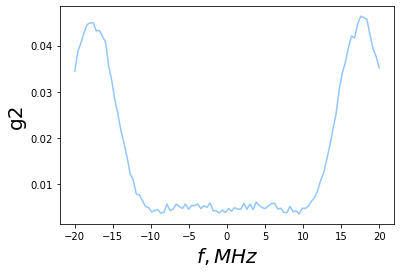

In [80]:
fig1, axes = plt.subplots(1,1)
axes.plot(scan/(2*np.pi),(np.array(g1_3atoms).T)[1])
#axes.set_xlim(-20, 20)
axes.set_xlabel(r'$f, MHz$', fontsize=20)
axes.set_ylabel(r"g2", fontsize=20);

In [95]:
#additional data after 3s 
time = np.linspace(0, 5, 20)

g1_3atoms_long = []
#g2 = []
for i in range(0,len(scan)):
    LIGHT_PARAMETERS[dlc] =scan[i]
    ATOM_PARAMETERS[dla] = [scan[i] for j in range(NUMBER_OF_ATOMS)]
    c_ops_scan = get_total_collapse_ops(LIGHT_PARAMETERS)
    Htotal_many_scan = get_total_Hamilt(get_many_atom_Ha(get_many_atom_Ha_bare(NUMBER_OF_ATOMS, at_ge_many, at_er_many, at_rr2_many), ATOM_PARAMETERS, NUMBER_OF_ATOMS),\
                                   get_many_atom_Hopt(Hopt, LIGHT_PARAMETERS),\
                                   get_many_atom_Hmm(Hmm, ATOM_PARAMETERS),\
                                   get_many_atom_Hi(get_many_atom_Hi_bare(NUMBER_OF_ATOMS, at_ge_many, at_er_many, at_rr2_many, a_opt, a_mm), ATOM_PARAMETERS, NUMBER_OF_ATOMS),\
                                   get_many_atom_Hdrive(Vopt, LIGHT_PARAMETERS))
    #result.append(qt.expect(Hopt, qt.steadystate(Htotal_many, c_ops, method ='power',use_rcm=True, maxiter = 100)))
    avg = qt.mcsolve(Htotal_many_scan, psi0, time, c_ops_scan, [a_opt.dag()*a_opt]).expect[0]
    #G2 = qt.correlation_3op_1t(Htotal_many_scan, psi0, time, c_ops_scan, a_opt.dag(), a_opt.dag()*a_opt, a_opt, solver='mc')
    #g2_temp = G2/(avg[0]*avg)
    #g2.append(g2_temp)
    g1_3atoms_long.append(avg)

10.0%. Run time:   4.85s. Est. time left: 00:00:00:43
20.0%. Run time:   6.02s. Est. time left: 00:00:00:24
30.0%. Run time:   7.19s. Est. time left: 00:00:00:16
40.0%. Run time:   8.34s. Est. time left: 00:00:00:12
50.0%. Run time:   9.54s. Est. time left: 00:00:00:09
60.0%. Run time:  10.67s. Est. time left: 00:00:00:07
70.0%. Run time:  11.80s. Est. time left: 00:00:00:05
80.0%. Run time:  12.94s. Est. time left: 00:00:00:03
90.0%. Run time:  14.11s. Est. time left: 00:00:00:01
100.0%. Run time:  15.20s. Est. time left: 00:00:00:00
Total run time:  15.26s
10.0%. Run time:   4.83s. Est. time left: 00:00:00:43
20.0%. Run time:   6.09s. Est. time left: 00:00:00:24
30.0%. Run time:   7.23s. Est. time left: 00:00:00:16
40.0%. Run time:   8.34s. Est. time left: 00:00:00:12
50.0%. Run time:   9.43s. Est. time left: 00:00:00:09
60.0%. Run time:  10.53s. Est. time left: 00:00:00:07
70.0%. Run time:  11.72s. Est. time left: 00:00:00:05
80.0%. Run time:  12.91s. Est. time left: 00:00:00:03
90.

70.0%. Run time:   9.69s. Est. time left: 00:00:00:04
80.0%. Run time:  10.63s. Est. time left: 00:00:00:02
90.0%. Run time:  11.49s. Est. time left: 00:00:00:01
100.0%. Run time:  12.34s. Est. time left: 00:00:00:00
Total run time:  12.42s
10.0%. Run time:   4.54s. Est. time left: 00:00:00:40
20.0%. Run time:   5.41s. Est. time left: 00:00:00:21
30.0%. Run time:   6.24s. Est. time left: 00:00:00:14
40.0%. Run time:   7.03s. Est. time left: 00:00:00:10
50.0%. Run time:   7.88s. Est. time left: 00:00:00:07
60.0%. Run time:   8.76s. Est. time left: 00:00:00:05
70.0%. Run time:   9.60s. Est. time left: 00:00:00:04
80.0%. Run time:  10.41s. Est. time left: 00:00:00:02
90.0%. Run time:  11.28s. Est. time left: 00:00:00:01
100.0%. Run time:  12.08s. Est. time left: 00:00:00:00
Total run time:  12.13s
10.0%. Run time:   4.55s. Est. time left: 00:00:00:40
20.0%. Run time:   5.41s. Est. time left: 00:00:00:21
30.0%. Run time:   6.21s. Est. time left: 00:00:00:14
40.0%. Run time:   7.03s. Est. t

20.0%. Run time:   4.77s. Est. time left: 00:00:00:19
30.0%. Run time:   5.37s. Est. time left: 00:00:00:12
40.0%. Run time:   5.98s. Est. time left: 00:00:00:08
50.0%. Run time:   6.56s. Est. time left: 00:00:00:06
60.0%. Run time:   7.19s. Est. time left: 00:00:00:04
70.0%. Run time:   7.77s. Est. time left: 00:00:00:03
80.0%. Run time:   8.38s. Est. time left: 00:00:00:02
90.0%. Run time:   8.95s. Est. time left: 00:00:00:00
100.0%. Run time:   9.54s. Est. time left: 00:00:00:00
Total run time:   9.61s
10.0%. Run time:   4.12s. Est. time left: 00:00:00:37
20.0%. Run time:   4.70s. Est. time left: 00:00:00:18
30.0%. Run time:   5.29s. Est. time left: 00:00:00:12
40.0%. Run time:   5.89s. Est. time left: 00:00:00:08
50.0%. Run time:   6.54s. Est. time left: 00:00:00:06
60.0%. Run time:   7.14s. Est. time left: 00:00:00:04
70.0%. Run time:   7.70s. Est. time left: 00:00:00:03
80.0%. Run time:   8.27s. Est. time left: 00:00:00:02
90.0%. Run time:   8.87s. Est. time left: 00:00:00:00
100

80.0%. Run time:   6.43s. Est. time left: 00:00:00:01
90.0%. Run time:   6.81s. Est. time left: 00:00:00:00
100.0%. Run time:   7.16s. Est. time left: 00:00:00:00
Total run time:   7.23s
10.0%. Run time:   3.81s. Est. time left: 00:00:00:34
20.0%. Run time:   4.17s. Est. time left: 00:00:00:16
30.0%. Run time:   4.52s. Est. time left: 00:00:00:10
40.0%. Run time:   4.86s. Est. time left: 00:00:00:07
50.0%. Run time:   5.20s. Est. time left: 00:00:00:05
60.0%. Run time:   5.55s. Est. time left: 00:00:00:03
70.0%. Run time:   5.89s. Est. time left: 00:00:00:02
80.0%. Run time:   6.26s. Est. time left: 00:00:00:01
90.0%. Run time:   6.60s. Est. time left: 00:00:00:00
100.0%. Run time:   6.94s. Est. time left: 00:00:00:00
Total run time:   7.01s
10.0%. Run time:   3.87s. Est. time left: 00:00:00:34
20.0%. Run time:   4.20s. Est. time left: 00:00:00:16
30.0%. Run time:   4.56s. Est. time left: 00:00:00:10
40.0%. Run time:   4.89s. Est. time left: 00:00:00:07
50.0%. Run time:   5.23s. Est. t

30.0%. Run time:   4.76s. Est. time left: 00:00:00:11
40.0%. Run time:   5.17s. Est. time left: 00:00:00:07
50.0%. Run time:   5.56s. Est. time left: 00:00:00:05
60.0%. Run time:   5.97s. Est. time left: 00:00:00:03
70.0%. Run time:   6.37s. Est. time left: 00:00:00:02
80.0%. Run time:   6.77s. Est. time left: 00:00:00:01
90.0%. Run time:   7.16s. Est. time left: 00:00:00:00
100.0%. Run time:   7.54s. Est. time left: 00:00:00:00
Total run time:   7.61s
10.0%. Run time:   3.90s. Est. time left: 00:00:00:35
20.0%. Run time:   4.34s. Est. time left: 00:00:00:17
30.0%. Run time:   4.78s. Est. time left: 00:00:00:11
40.0%. Run time:   5.18s. Est. time left: 00:00:00:07
50.0%. Run time:   5.61s. Est. time left: 00:00:00:05
60.0%. Run time:   6.03s. Est. time left: 00:00:00:04
70.0%. Run time:   6.44s. Est. time left: 00:00:00:02
80.0%. Run time:   6.84s. Est. time left: 00:00:00:01
90.0%. Run time:   7.26s. Est. time left: 00:00:00:00
100.0%. Run time:   7.66s. Est. time left: 00:00:00:00
To

90.0%. Run time:   9.36s. Est. time left: 00:00:00:01
100.0%. Run time:   9.94s. Est. time left: 00:00:00:00
Total run time:  10.00s
10.0%. Run time:   4.12s. Est. time left: 00:00:00:37
20.0%. Run time:   4.80s. Est. time left: 00:00:00:19
30.0%. Run time:   5.47s. Est. time left: 00:00:00:12
40.0%. Run time:   6.14s. Est. time left: 00:00:00:09
50.0%. Run time:   6.77s. Est. time left: 00:00:00:06
60.0%. Run time:   7.40s. Est. time left: 00:00:00:04
70.0%. Run time:   8.05s. Est. time left: 00:00:00:03
80.0%. Run time:   8.71s. Est. time left: 00:00:00:02
90.0%. Run time:   9.38s. Est. time left: 00:00:00:01
100.0%. Run time:  10.00s. Est. time left: 00:00:00:00
Total run time:  10.07s
10.0%. Run time:   4.24s. Est. time left: 00:00:00:38
20.0%. Run time:   4.93s. Est. time left: 00:00:00:19
30.0%. Run time:   5.62s. Est. time left: 00:00:00:13
40.0%. Run time:   6.33s. Est. time left: 00:00:00:09
50.0%. Run time:   7.01s. Est. time left: 00:00:00:07
60.0%. Run time:   7.71s. Est. t

40.0%. Run time:   8.52s. Est. time left: 00:00:00:12
50.0%. Run time:   9.56s. Est. time left: 00:00:00:09
60.0%. Run time:  10.65s. Est. time left: 00:00:00:07
70.0%. Run time:  11.70s. Est. time left: 00:00:00:05
80.0%. Run time:  12.88s. Est. time left: 00:00:00:03
90.0%. Run time:  14.01s. Est. time left: 00:00:00:01
100.0%. Run time:  15.12s. Est. time left: 00:00:00:00
Total run time:  15.19s
10.0%. Run time:   4.99s. Est. time left: 00:00:00:44
20.0%. Run time:   6.08s. Est. time left: 00:00:00:24
30.0%. Run time:   7.14s. Est. time left: 00:00:00:16
40.0%. Run time:   8.17s. Est. time left: 00:00:00:12
50.0%. Run time:   9.28s. Est. time left: 00:00:00:09
60.0%. Run time:  10.47s. Est. time left: 00:00:00:06
70.0%. Run time:  11.52s. Est. time left: 00:00:00:04
80.0%. Run time:  12.63s. Est. time left: 00:00:00:03
90.0%. Run time:  13.69s. Est. time left: 00:00:00:01
100.0%. Run time:  14.67s. Est. time left: 00:00:00:00
Total run time:  14.73s
10.0%. Run time:   4.68s. Est. t

In [16]:
scan = np.linspace(-20*2*np.pi, 20*2*np.pi, 100)[12:]

In [ ]:
#5 atoms/sqrtNatoms
time = np.linspace(0, 5, 20)

g1_5atoms_2 = []
#g2 = []
for i in range(0,len(scan)):
    LIGHT_PARAMETERS[dlc] =scan[i]
    ATOM_PARAMETERS[dla] = [scan[i] for j in range(NUMBER_OF_ATOMS)]
    c_ops_scan = get_total_collapse_ops(LIGHT_PARAMETERS)
    Htotal_many_scan = get_total_Hamilt(get_many_atom_Ha(get_many_atom_Ha_bare(NUMBER_OF_ATOMS, at_ge_many, at_er_many, at_rr2_many), ATOM_PARAMETERS, NUMBER_OF_ATOMS),\
                                   get_many_atom_Hopt(Hopt, LIGHT_PARAMETERS),\
                                   get_many_atom_Hmm(Hmm, ATOM_PARAMETERS),\
                                   get_many_atom_Hi(get_many_atom_Hi_bare(NUMBER_OF_ATOMS, at_ge_many, at_er_many, at_rr2_many, a_opt, a_mm), ATOM_PARAMETERS, NUMBER_OF_ATOMS),\
                                   get_many_atom_Hdrive(Vopt, LIGHT_PARAMETERS))
    #result.append(qt.expect(Hopt, qt.steadystate(Htotal_many, c_ops, method ='power',use_rcm=True, maxiter = 100)))
    avg = qt.mcsolve(Htotal_many_scan, psi0, time, c_ops_scan, [a_opt.dag()*a_opt]).expect[0]
    #G2 = qt.correlation_3op_1t(Htotal_many_scan, psi0, time, c_ops_scan, a_opt.dag(), a_opt.dag()*a_opt, a_opt, solver='mc')
    #g2_temp = G2/(avg[0]*avg)
    #g2.append(g2_temp)
    g1_5atoms_2.append(avg)

10.0%. Run time:  69.01s. Est. time left: 00:00:10:21
20.0%. Run time: 125.08s. Est. time left: 00:00:08:20
30.0%. Run time: 180.45s. Est. time left: 00:00:07:01
40.0%. Run time: 238.24s. Est. time left: 00:00:05:57
50.0%. Run time: 294.86s. Est. time left: 00:00:04:54
60.0%. Run time: 348.91s. Est. time left: 00:00:03:52
70.0%. Run time: 402.59s. Est. time left: 00:00:02:52
80.0%. Run time: 459.28s. Est. time left: 00:00:01:54
90.0%. Run time: 516.74s. Est. time left: 00:00:00:57
100.0%. Run time: 562.35s. Est. time left: 00:00:00:00
Total run time: 562.47s
10.0%. Run time:  67.33s. Est. time left: 00:00:10:05
20.0%. Run time: 120.32s. Est. time left: 00:00:08:01
30.0%. Run time: 175.24s. Est. time left: 00:00:06:48
40.0%. Run time: 231.09s. Est. time left: 00:00:05:46
50.0%. Run time: 283.77s. Est. time left: 00:00:04:43
60.0%. Run time: 338.82s. Est. time left: 00:00:03:45
70.0%. Run time: 392.61s. Est. time left: 00:00:02:48
80.0%. Run time: 445.99s. Est. time left: 00:00:01:51
90.

70.0%. Run time: 324.55s. Est. time left: 00:00:02:19
80.0%. Run time: 367.46s. Est. time left: 00:00:01:31
90.0%. Run time: 413.06s. Est. time left: 00:00:00:45
100.0%. Run time: 452.12s. Est. time left: 00:00:00:00
Total run time: 452.26s
10.0%. Run time:  50.49s. Est. time left: 00:00:07:34
20.0%. Run time:  94.23s. Est. time left: 00:00:06:16
30.0%. Run time: 135.05s. Est. time left: 00:00:05:15
40.0%. Run time: 179.13s. Est. time left: 00:00:04:28
50.0%. Run time: 220.94s. Est. time left: 00:00:03:40
60.0%. Run time: 260.56s. Est. time left: 00:00:02:53
70.0%. Run time: 305.11s. Est. time left: 00:00:02:10
80.0%. Run time: 350.26s. Est. time left: 00:00:01:27
90.0%. Run time: 393.84s. Est. time left: 00:00:00:43
100.0%. Run time: 431.05s. Est. time left: 00:00:00:00
Total run time: 431.17s
10.0%. Run time:  50.00s. Est. time left: 00:00:07:29
20.0%. Run time:  89.32s. Est. time left: 00:00:05:57
30.0%. Run time: 133.20s. Est. time left: 00:00:05:10
40.0%. Run time: 172.65s. Est. t

20.0%. Run time:  46.20s. Est. time left: 00:00:03:04
30.0%. Run time:  66.54s. Est. time left: 00:00:02:35
40.0%. Run time:  85.99s. Est. time left: 00:00:02:08
50.0%. Run time: 106.96s. Est. time left: 00:00:01:46
60.0%. Run time: 126.38s. Est. time left: 00:00:01:24
70.0%. Run time: 146.44s. Est. time left: 00:00:01:02
80.0%. Run time: 168.03s. Est. time left: 00:00:00:42
90.0%. Run time: 191.29s. Est. time left: 00:00:00:21
100.0%. Run time: 209.65s. Est. time left: 00:00:00:00
Total run time: 209.79s
10.0%. Run time:  24.08s. Est. time left: 00:00:03:36
20.0%. Run time:  42.90s. Est. time left: 00:00:02:51
30.0%. Run time:  62.21s. Est. time left: 00:00:02:25
40.0%. Run time:  80.54s. Est. time left: 00:00:02:00
50.0%. Run time:  98.95s. Est. time left: 00:00:01:38
60.0%. Run time: 117.10s. Est. time left: 00:00:01:18
70.0%. Run time: 136.73s. Est. time left: 00:00:00:58
80.0%. Run time: 155.63s. Est. time left: 00:00:00:38
90.0%. Run time: 174.47s. Est. time left: 00:00:00:19
100

80.0%. Run time: 131.33s. Est. time left: 00:00:00:32
90.0%. Run time: 147.21s. Est. time left: 00:00:00:16
100.0%. Run time: 160.81s. Est. time left: 00:00:00:00
Total run time: 160.95s
10.0%. Run time:  22.01s. Est. time left: 00:00:03:18
20.0%. Run time:  39.35s. Est. time left: 00:00:02:37
30.0%. Run time:  56.82s. Est. time left: 00:00:02:12
40.0%. Run time:  74.18s. Est. time left: 00:00:01:51
50.0%. Run time:  91.03s. Est. time left: 00:00:01:31
60.0%. Run time: 107.74s. Est. time left: 00:00:01:11
70.0%. Run time: 124.05s. Est. time left: 00:00:00:53
80.0%. Run time: 140.97s. Est. time left: 00:00:00:35
90.0%. Run time: 157.65s. Est. time left: 00:00:00:17
100.0%. Run time: 172.71s. Est. time left: 00:00:00:00
Total run time: 172.86s
10.0%. Run time:  24.63s. Est. time left: 00:00:03:41
20.0%. Run time:  43.60s. Est. time left: 00:00:02:54
30.0%. Run time:  61.13s. Est. time left: 00:00:02:22
40.0%. Run time:  79.83s. Est. time left: 00:00:01:59
50.0%. Run time:  97.92s. Est. t

30.0%. Run time: 118.22s. Est. time left: 00:00:04:35
40.0%. Run time: 156.40s. Est. time left: 00:00:03:54
50.0%. Run time: 196.05s. Est. time left: 00:00:03:16
60.0%. Run time: 235.77s. Est. time left: 00:00:02:37
70.0%. Run time: 276.13s. Est. time left: 00:00:01:58
80.0%. Run time: 320.50s. Est. time left: 00:00:01:20
90.0%. Run time: 363.34s. Est. time left: 00:00:00:40
100.0%. Run time: 396.41s. Est. time left: 00:00:00:00
Total run time: 396.56s
10.0%. Run time:  49.61s. Est. time left: 00:00:07:26
20.0%. Run time:  89.96s. Est. time left: 00:00:05:59
30.0%. Run time: 131.23s. Est. time left: 00:00:05:06
40.0%. Run time: 174.51s. Est. time left: 00:00:04:21
50.0%. Run time: 215.75s. Est. time left: 00:00:03:35
60.0%. Run time: 259.04s. Est. time left: 00:00:02:52
70.0%. Run time: 301.46s. Est. time left: 00:00:02:09
80.0%. Run time: 344.88s. Est. time left: 00:00:01:26
90.0%. Run time: 386.47s. Est. time left: 00:00:00:42
100.0%. Run time: 421.69s. Est. time left: 00:00:00:00
To

In [84]:
g1_3atoms_total = g1_3atoms + g1_3atoms_3_5

In [111]:
#save 3 atom fileles 
from tempfile import TemporaryFile
with open('g1_3atoms_long.npy', 'wb') as f:
    np.save(f, g1_3atoms_long)

In [112]:
#save 5 atom file
from tempfile import TemporaryFile
with open('g1_5atoms_interupted.npy', 'wb') as f:
    np.save(f, g1_5atoms) 

In [113]:
#save 5 atom file
from tempfile import TemporaryFile
with open('g1_3atoms_added.npy', 'wb') as f:
    np.save(f, g1_3atoms_total) 

In [114]:
#save 5 atom file
from tempfile import TemporaryFile
with open('g1_1atom.npy', 'wb') as f:
    np.save(f, g1) 

In [63]:
print((np.array(result).T)[0])
fig1, axes = plt.subplots(1,1)
axes.plot(scan/(2*np.pi), (np.array(result).T)[60])
#axes.set_xlim(-20, 20)
axes.set_xlabel(r'$f, MHz$', fontsize=20)
axes.set_ylabel(r"Spectra", fontsize=20);

NameError: name 'result' is not defined

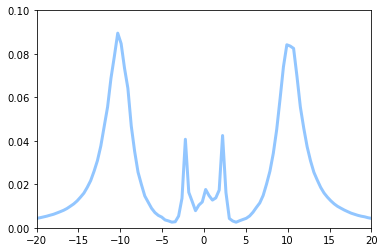

In [70]:
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')


fig = plt.figure()
ax = plt.axes(xlim=(-20, 20), ylim=(0, .1))
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    x = scan/(2*np.pi)
    y = (np.array(g1).T)[i]
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=20, interval=20, blit=True)


anim.save('spectrum.mp4')

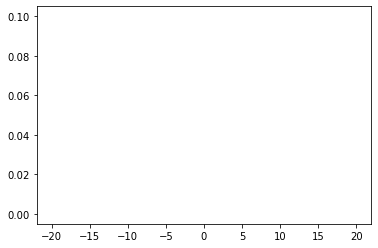

In [72]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output

t = scan/(2*np.pi)
x = (np.array(g1).T)

fig, ax = plt.subplots()
l, = ax.plot([-20,20],[0,.1])

animate = lambda i: l.set_data(t, x[i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(x))

from IPython.display import HTML
HTML(ani.to_html5_video())

# for i in range(len(x)-1):
#     animate(i)
#     clear_output(wait=True)
#     display(fig)


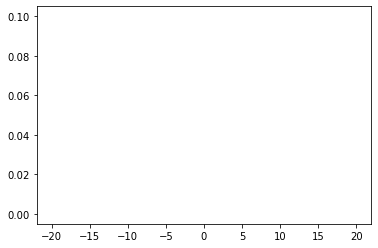

In [96]:
#3 atom animation spectra
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output

t = scan/(2*np.pi)
x = (np.array(g1_3atoms_long).T)

fig, ax = plt.subplots()
l, = ax.plot([-20,20],[0,.1])

animate = lambda i: l.set_data(t, x[i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(time))

from IPython.display import HTML
HTML(ani.to_html5_video())


In [90]:
np.array(g1_3atoms_total).T

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.03446475, 0.03870733, 0.04058471, ..., 0.04884352, 0.04734856,
        0.04944958],
       [0.03607231, 0.0455172 , 0.05474884, ..., 0.06315405, 0.05876278,
        0.05364478],
       ...,
       [0.02836817, 0.03466157, 0.04407053, ..., 0.04288543, 0.03492969,
        0.02825908],
       [0.0289942 , 0.03502705, 0.04352882, ..., 0.04264228, 0.03500543,
        0.02915455],
       [0.02871645, 0.03554772, 0.04349029, ..., 0.04369044, 0.03468471,
        0.02874506]])

In [34]:
#the actual Monte Carlo simulation
exp_nphot_mc = qt.mcsolve(Htotal_many_0, psi0, time, c_ops_0, [Hopt]).expect[0]

10.0%. Run time:  30.15s. Est. time left: 00:00:04:31
20.0%. Run time:  46.07s. Est. time left: 00:00:03:04
30.0%. Run time:  63.85s. Est. time left: 00:00:02:28
40.0%. Run time:  82.04s. Est. time left: 00:00:02:03
50.0%. Run time: 101.45s. Est. time left: 00:00:01:41
60.0%. Run time: 119.53s. Est. time left: 00:00:01:19
70.0%. Run time: 138.47s. Est. time left: 00:00:00:59
80.0%. Run time: 156.34s. Est. time left: 00:00:00:39
90.0%. Run time: 174.20s. Est. time left: 00:00:00:19
100.0%. Run time: 189.60s. Est. time left: 00:00:00:00
Total run time: 189.73s


In [37]:
# calculate the correlation function G2 and normalize with n(0)n(t) to
# obtain g2
G2 = qt.correlation_3op_1t(Htotal_many_0, psi0, time, c_ops_0, a_opt.dag(), a_opt.dag()*a_opt, a_opt)
g2 = np.real((G2 / (exp_nphot_mc[0] * exp_nphot_mc)))

KeyboardInterrupt: 

In [ ]:
# plot the spectra
fig = plt.figure(figsize=(15,5))
ax = fig.subplots(1, 2)
ax[0].plot(time, exp_nphot_me, 'b', lw=2, label='ME method')
ax[0].plot(time, exp_nphot_mc, 'r', lw=2, label='MC method')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Number of photons')
ax[0].set_title('Number of photons')
ax[0].set_xlim(0, 3)
ax[0].legend()
ax[1].plot(time, g2, 'b')
ax[1].set_xlabel('Tau')
ax[1].set_ylabel('g2')
ax[1].set_title('g2')
ax[1].set_xlim(0, 5)
plt.show()

In [31]:
ax[1].plot(time, g2, 'b')
ax[1].set_xlabel('Tau')
ax[1].set_ylabel('g2')
ax[1].set_title('g2')
ax[1].set_xlim(0, 5)
plt.show()